# setup

In [1]:
import socket
import os

hostname = socket.gethostname()
if hostname == 'simurgh':
    os.environ["CUDA_VISIBLE_DEVICES"] = "MIG-b5356651-0d8e-5cd1-bdf3-ccbb8b221031"
    
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import tuning_fun as tu
import emulator_fun as ef
import numpy as np
from tqdm.keras import TqdmCallback
import pandas as pd
import time
import netCDF4 as nc
import load_ppe_fun as lp
from tensorflow.keras import layers
import keras
from tensorflow.keras.callbacks import TerminateOnNaN
from scipy.stats import boxcox
from tqdm.auto import tqdm
import MCMC_fun as mf
import util_fun as uf
import importlib
import tensorflow_probability as tfp
import arviz as az

2025-09-28 21:30:52.107869: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-28 21:30:52.121048: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759109452.133545 1514294 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759109452.137378 1514294 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1759109452.148741 1514294 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
# set up and check if GPU is being used


gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
        #     tf.config.experimental.set_virtual_device_configuration(
        #     gpu,
        #     [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=20480)]
        # )
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

print(gpus)

Physical devices cannot be modified after being initialized
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# HP tuning

## pre-processing

In [67]:
importlib.reload(ef)

<module 'emulator_fun' from '/home/arthurhu/BOSS_PPE/emulator_fun.py'>

In [68]:
run_name = 'fullmp_ppe_r0_cov_last2hrmean_per5lvl'
filename = run_name + '_N500.nc'

params_train = ef.get_params(lp.nc_dir, filename)
transform_method = 'standard_scaler_asinh'
x_train, x_val, y_train, y_val, tgt_data, tgt_initvar_matrix, ppe_info, scalers = \
    ef.get_train_val_tgt_data(lp.nc_dir, filename, params_train, transform_method, 
                              l_multi_output=False, set_nan_to_neg1001=True)

nobs = ppe_info['nobs']
nvar = ppe_info['nvar']
npar = ppe_info['npar']
n_init = ppe_info['n_init']
nparam_init = ppe_info['nparam_init']

Transforming data...:   0%|          | 0/9 [00:00<?, ?it/s]

Transforming data...: 100%|██████████| 9/9 [00:00<00:00, 1009.05it/s]


In [69]:
# fig = plt.figure(figsize=(15, 5))
# gs = gridspec.GridSpec(1,nvar)
# for i, eff0 in enumerate(eff0s):
#     ax = fig.add_subplot(gs[i])
#     _ = plt.hist([ppe_data[i].flatten(), tgt_data[i].flatten()],
#                  bins=100,
#                  density=True,
#                  label=['BOSS PPE', 'target'])
#     plt.legend()
#     # plt.yscale('log')
#     plt.title(var_constraints[i])

Next, try out different ML architectures...

## CRPS

In [80]:
importlib.reload(tu)

<module 'tuning_fun' from '/home/arthurhu/BOSS_PPE/tuning_fun.py'>

In [81]:
proj_name = 'crps_' + run_name + '_' + transform_method
varcons = ppe_info['var_constraints']
y_train_nopres = {k: v for k, v in y_train.items() if 'presence_' not in k}
y_val_nopres = {k: v for k, v in y_val.items() if 'presence_' not in k}

nparam_init = ppe_info['nparam_init']
tuner = kt.RandomSearch(
    lambda hp: tu.build_reg_crps_model(hp, nparam_init, varcons, nobs),
    objective="val_loss",
    max_trials=25,
    directory='hp_tuning/crps',
    project_name=proj_name,
)

stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(
    x_train,
    y_train_nopres,
    epochs=25,
    validation_data=(x_val, y_val_nopres),
    callbacks=([stop_early, TerminateOnNaN()])
)

# Retrieve the best hyperparameters and build the best model:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hp)

Reloading Tuner from hp_tuning/crps/crps_fullmp_ppe_r0_cov_last2hrmean_per5lvl_standard_scaler_asinh/tuner0.json


In [82]:
best_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 24)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 256)       │      6,400 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 192)       │     49,344 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 128)       │     24,704 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 64)        │      8,256 │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ M0_per5lvl_last2hr… │ (None, 28)        │      1,820 │ dense_12[0][0]    │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ M3_per5lvl_last2hr… │ (None, 28)        │      1,820 │ dense_12[0][0]    │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ M4_per5lvl_last2hr… │ (None, 28)        │      1,820 │ dense_12[0][0]    │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ M6_per5lvl_last2hr… │ (None, 28)        │      1,820 │ dense_12[0][0]    │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ prate_dm_last2hrme… │ (None, 2)         │        130 │ dense_12[0][0]    │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sfM0_per5lvl_last2… │ (None, 28)        │      1,820 │ dense_12[0][0]    │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sfM3_per5lvl_last2… │ (None, 28)        │      1,820 │ dense_12[0][0]    │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sfM4_per5lvl_last2… │ (None, 28)        │      1,820 │ dense_12[0][0]    │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sfM6_per5lvl_last2… │ (None, 28)        │      1,820 │ dense_12[0][0]    │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 103,394 (403.88 KB)

 Trainable params: 103,394 (403.88 KB)

 Non-trainable params: 0 (0.00 B)

In [83]:
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=50)

history = best_model.fit(
    x=x_train,
    y=y_train_nopres,
    epochs=1000,
    verbose=0,
    validation_data=(x_val, y_val_nopres),
    callbacks=[TqdmCallback(verbose=1), stop_early]
)

# save model:
best_model.save(f'models/{proj_name}.keras')

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

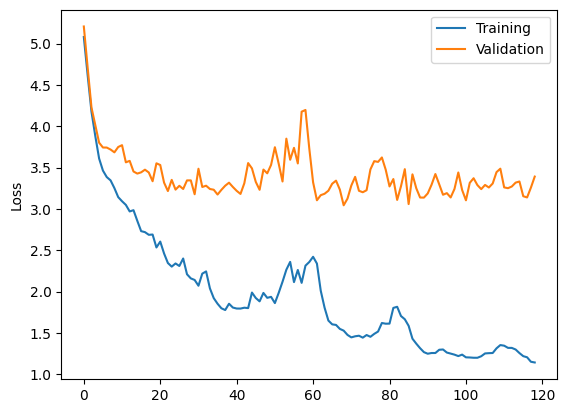

In [84]:
plt.figure()
plt.plot(history.epoch, history.history['loss'], label='Training')
plt.plot(history.epoch, history.history['val_loss'], label='Validation')
plt.ylabel('Loss')
plt.legend()

## multi-output (explicit) model

In [5]:
importlib.reload(tu)

<module 'tuning_fun' from '/home/arthurhu/BOSS_PPE/tuning_fun.py'>

In [ ]:
proj_name = 'multioutput_unc_' + run_name + '_' + transform_method
varcons = ppe_info['var_constraints']
nparam_init = ppe_info['nparam_init']
tuner = kt.RandomSearch(
    lambda hp: tu.build_classreg_unc_model_simple(hp, nparam_init, varcons, nobs),
    objective="val_loss",
    max_trials=25,
    directory='hp_tuning/multi-output',
    project_name=proj_name,
)

stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(
    x_train,
    y_train,
    epochs=25,
    validation_data=(x_val, y_val),
    callbacks=([stop_early, TerminateOnNaN()])
)

# Retrieve the best hyperparameters and build the best model:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hp)

Trial 25 Complete [00h 01m 47s]
val_loss: 1.1667722463607788

Best val_loss So Far: 1.065772294998169
Total elapsed time: 01h 13m 25s


In [7]:
best_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 18)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 96)        │      1,824 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 192)       │     18,624 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 192)       │     37,056 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 96)        │     18,528 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 160)       │     15,520 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ M0 (Dense)          │ (None, 85680)     │ 13,794,480 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ M3 (Dense)          │ (None, 85680)     │ 13,794,480 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Mx (Dense)          │ (None, 85680)     │ 13,794,480 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ My (Dense)          │ (None, 85680)     │ 13,794,480 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ presence_M0 (Dense) │ (None, 42840)     │  6,897,240 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ presence_M3 (Dense) │ (None, 42840)     │  6,897,240 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ presence_Mx (Dense) │ (None, 42840)     │  6,897,240 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ presence_My (Dense) │ (None, 42840)     │  6,897,240 │ dense_9[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 82,858,432 (316.08 MB)

 Trainable params: 82,858,432 (316.08 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=50)

history = best_model.fit(
    x=x_train,
    y=y_train,
    epochs=10000,
    verbose=0,
    validation_data=(x_val, y_val),
    callbacks=[TqdmCallback(verbose=1), stop_early]
)

# save model:
best_model.save(f'models/{proj_name}.keras')

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

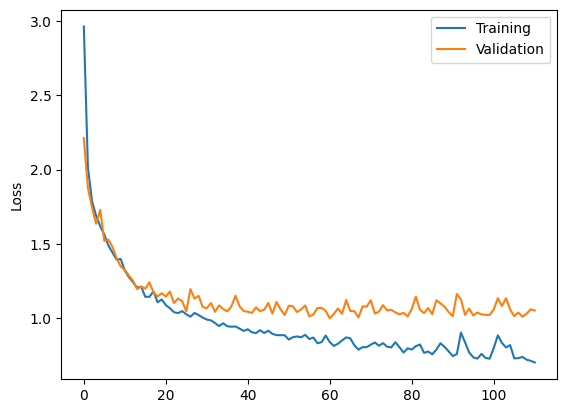

In [9]:
plt.figure()
plt.plot(history.epoch, history.history['loss'], label='Training')
plt.plot(history.epoch, history.history['val_loss'], label='Validation')
plt.ylabel('Loss')
plt.legend()

## validation

In [85]:
# proj_name = 'crps_fullmp_ppe_r0_cov_last2hrmean_prate_sedflux_standard_scaler_asinh'
# best_model = tf.keras.models.load_model('models/' + proj_name + '.keras', compile=False)

In [86]:
importlib.reload(ef)

<module 'emulator_fun' from '/home/arthurhu/BOSS_PPE/emulator_fun.py'>

In [87]:
best_model(x_val[:1,:]).keys()

dict_keys(['M0_per5lvl_last2hrmean', 'M3_per5lvl_last2hrmean', 'M4_per5lvl_last2hrmean', 'M6_per5lvl_last2hrmean', 'prate_dm_last2hrmean', 'sfM0_per5lvl_last2hrmean', 'sfM3_per5lvl_last2hrmean', 'sfM4_per5lvl_last2hrmean', 'sfM6_per5lvl_last2hrmean'])

/home/arthurhu/BOSS_PPE/emulator_fun.py:441: RuntimeWarning: overflow encountered in sinh
  inv_smooth_linlog = lambda y, eff0: eff0*np.sinh(y/eff0)
/home/arthurhu/BOSS_PPE/emulator_fun.py:441: RuntimeWarning: overflow encountered in sinh
  inv_smooth_linlog = lambda y, eff0: eff0*np.sinh(y/eff0)
/home/arthurhu/BOSS_PPE/emulator_fun.py:441: RuntimeWarning: overflow encountered in sinh
  inv_smooth_linlog = lambda y, eff0: eff0*np.sinh(y/eff0)
/home/arthurhu/BOSS_PPE/emulator_fun.py:441: RuntimeWarning: overflow encountered in sinh
  inv_smooth_linlog = lambda y, eff0: eff0*np.sinh(y/eff0)


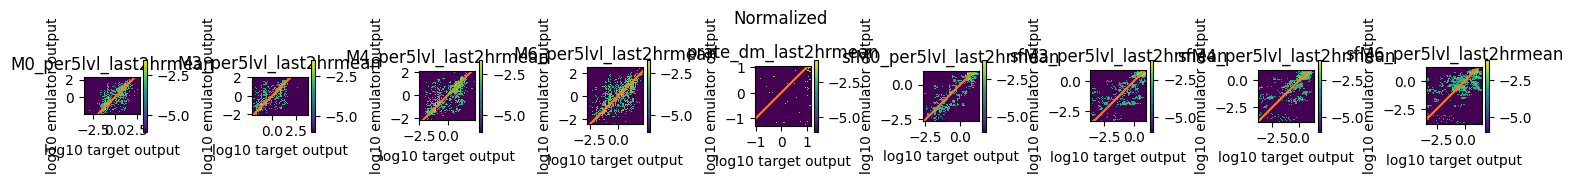

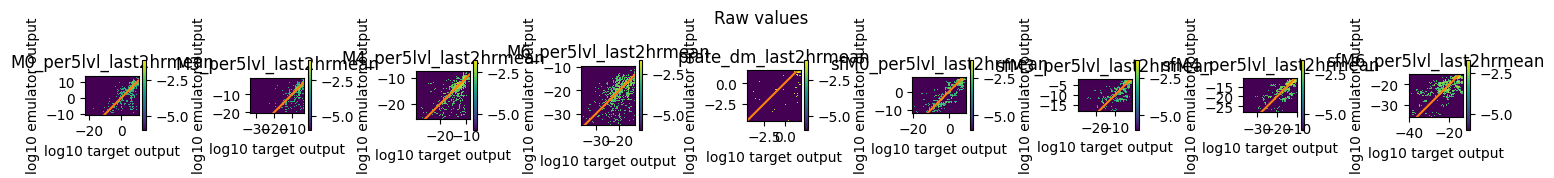

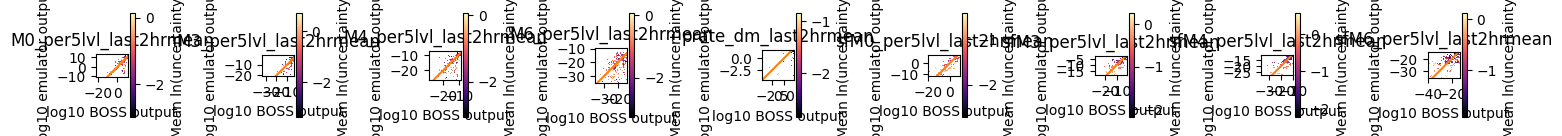

In [88]:
ef.plot_emulator_results(x_val, y_val, best_model, ppe_info, transform_method, scalers, plot_uncertainty=True)

In [89]:
# List top memory variables
# top_vars = uf.get_top_memory_vars(globals())
uf.detailed_memory_analysis()
# # Free likely iterated/temporary variables
# free_iterated_vars(locals())

# # Optionally, show top memory variables again after cleanup
# print("\nAfter cleanup:")
# get_top_memory_vars(locals())

=== Memory Analysis ===
RSS (Resident Set Size): 14.95 GB
VMS (Virtual Memory Size): 160.10 GB
Shared Memory: 0.63 GB
Text Segment: 0.00 GB
Data Segment: 24.70 GB


# MCMC

## setup

In [90]:
# proj_name = 'crps_condcoal_46_momvals_standard_scaler_asinh'
# best_model = tf.keras.models.load_model('models/' + proj_name + '.keras', compile=False)

In [101]:
# MCMC
nchains = 8
num_burnin_steps = 5000
num_samples = 10000

# log prob function related
tau = 0.05
inflate_factor = .2

In [102]:
param_interest_idx = params_train['param_interest_idx']

orig_param_csv = f'{lp.param_dir}param_NCE_predNc_actwidth_r1_dfl0.3_last2hrmean_r2.csv'

param_table = pd.read_csv(orig_param_csv)
param_names = param_table.columns[1+param_interest_idx].to_list()
all_param_names = param_table.columns[1:].to_list()

# target_param_table = pd.read_csv(target_param_csv)

param_mean = param_table.values[0, 1+param_interest_idx].astype(np.float32)
param_std = param_table.values[2, 1+param_interest_idx].astype(np.float32)
# target_param_mean = target_param_table.values[0, 1+param_interest_idx].astype(np.float32)
nparam = len(param_names)

print_table = pd.DataFrame({'param names': param_names, 'prior mean': param_mean, 'prior std': param_std})
print(print_table)

   param names  prior mean   prior std
0    a0coal_db  -86.872787   13.064348
1       bmcoal    1.114888    0.828837
2      bn0coal    2.176518    0.651858
3      bnxcoal    2.110249    0.664934
4      bnycoal    2.040299    0.692300
5      bx0coal    0.955827    0.937546
6      bxxcoal    1.416141    1.137753
7      bxycoal    2.409513    1.493816
8      by0coal    0.767179    1.242940
9      byxcoal    2.012912    1.569157
10     byycoal    3.901877    2.132202
11  mtrans0_db   -5.051001   23.119673
12    afall_db    8.679640  109.324944
13      bnfall    1.542066   22.026426
14     bx0fall   -0.383535    1.356642
15     bx3fall    0.937090    1.481585
16     bxxfall    0.878926    1.554319
17     bxyfall    0.733513    1.949807
18     by0fall   -0.024706    1.993456
19     by3fall    0.510425    2.191994
20     byxfall    1.387850    2.303620
21     byyfall    2.727749    2.892624
22     mlim_db    9.035962   80.069885


In [103]:
tgt_data_tf32 = tf.concat([tf.cast(x, tf.float32) for x in tgt_data],axis=-1)

tgt_sim_ics = np.concatenate(tgt_initvar_matrix, axis=1)
nvar = len(ppe_info['var_constraints'])
n_tgt_ics = tgt_data[0].shape[0]

IC_with_dummy = np.concatenate((tgt_sim_ics, np.zeros([n_tgt_ics, npar])), axis=1)
IC_norm = scalers['x'].transform(IC_with_dummy)[:,:n_init].astype('float32')
IC_norm_3d = tf.tile(IC_norm[None, :, :], [nchains, 1, 1])
batch_size = nchains * n_tgt_ics
tgt_data_tf32_chain = tf.tile(tgt_data_tf32[None, :, :], [nchains, 1, 1])
varcons = ppe_info['var_constraints']

## set up log prob function

In [ ]:
tfd = tfp.distributions
tfb = tfp.bijectors
tfs = tfp.experimental.stats

def get_BOSSemu_lp(params_sigma, l_diag=False, use_loglik=True):
    emu_mu_list, emu_sigma_list, emu_pres_list = [], [], []
    sigma_list, obs_lp_list, y_true_safe_list, mu_safe_list = [], [], [], []
    
    # priors on parameters

    params = params_sigma
    params_3d = tf.tile(params[:, None, :], [1, n_tgt_ics, 1])
    theta=tfb.Sigmoid().forward(params_3d)
    param_lp = tf.reduce_sum(tf.math.log(theta) + tf.math.log1p(-theta), axis=[1,2])

    if l_diag:
        # print('input:', params_3d[0,0,:].numpy())
        print('scaled parameters:', theta[0,0,:].numpy())

    # likelihood
    input_norm3d = tf.concat([IC_norm_3d, theta], axis=-1) # nchains x n_tgt_ics x n_input
    input_norm2d  = tf.reshape(input_norm3d, [batch_size, nparam_init])
    y_emu = best_model(input_norm2d) # nvar * n_tgt_ics x nobs
    if type(y_emu) is dict:
        for i, varcon in enumerate(varcons):
            # set default presence value to 1 (true) if it's not a predicted by emulator (not by CRPS, yes by multioutput)
            pres = tf.ones([nchains, n_tgt_ics, nobs[i]], tf.float32)
            if f'presence_{varcon}' in y_emu.keys():
                pres   = tf.reshape(tf.cast(y_emu[f'presence_{varcon}'], tf.float32),
                                    [nchains, n_tgt_ics, nobs[i]])
            full   = tf.reshape(tf.cast(y_emu[varcon], tf.float32),
                                [nchains, n_tgt_ics, 2*nobs[i]])
            mu     = full[..., :nobs[i]]
            rawsig = full[..., nobs[i]:]  # raw scale; softplus later
            emu_pres_list.append(pres)
            emu_mu_list.append(mu)
            emu_sigma_list.append(tf.nn.softplus(rawsig) + 1e-6)
            
        emu_pres_chain  = tf.concat([p for p in emu_pres_list],  axis=-1)   # [chain, ic, var] 
        emu_mu_chain    = tf.concat([p for p in emu_mu_list],    axis=-1)
        emu_sigma_chain = tf.concat([p for p in emu_sigma_list], axis=-1)
        # print(emu_pres_rect.shape, emu_mu_rect.shape, emu_sigma_rect.shape, tf.stack(emu_pres_list[:5]).shape)
    else:
        raise ValueError('`y_emu` is not a dictionary. Not yet implemented.')

    for ichain in range(nchains):
        presence_pred = emu_pres_chain[ichain, ...]   # [nvar, n_ic, nobs]
        mu_pred       = emu_mu_chain[ichain, ...]
        sig_pred      = emu_sigma_chain[ichain, ...]
        y_true        = tgt_data_tf32                          # [nvar, n_ic, nobs]

        finite_mask = tf.math.is_finite(y_true)
        finite_w    = tf.stop_gradient(tf.cast(finite_mask, tf.float32))

        # soft presence gate (same as you had)
        thresh = tf.constant(0.1, tf.float32)
        tau    = tf.constant(0.05, tf.float32)
        w_soft = tf.sigmoid((presence_pred - thresh) / tau)

        w = finite_w * w_soft

        # safe tensors
        y_true_safe = tf.where(finite_mask, y_true, 0.0)
        mu_safe     = tf.where(finite_mask, mu_pred, 0.0)
        sig_safe    = tf.where(finite_mask, sig_pred, 0.0)
        
        #  Weighted scale (avoid NaN when few points are active)
        eps    = tf.constant(1e-6, tf.float32)
        w_sum  = tf.reduce_sum(w) + eps
        resid  = mu_safe - y_true_safe
        mean_w = tf.reduce_sum(w * resid) / w_sum
        var_w  = tf.reduce_sum(w * tf.square(resid - mean_w)) / w_sum
        sigma_eff = tf.sqrt(var_w + tf.square(sig_safe))
        
        if l_diag:
            sigma_list.append(sigma_eff)
            y_true_safe_list.append(y_true_safe)
            mu_safe_list.append(mu_safe)

        if use_loglik:
            # Weighted log-likelihood
            logpdf = tfd.Normal(loc=y_true_safe, scale=sigma_eff).log_prob(mu_safe)
            obs_lp_list.append(tf.reduce_sum(w * logpdf))
        else:
            # CRPS per point (univariate, closed form)
            crps = mf.gaussian_crps_per_point(y_true_safe, mu_safe, sig_safe)  # [nvar, n_ic, nobs]
            score_chain = tf.reduce_sum(w * crps)   # average CRPS over active points
            obs_lp_list.append(-score_chain)
            
    obs_lp = tf.stack(obs_lp_list)                   # shape [nchains]
        
    if l_diag:
        print('param_lp:', param_lp.numpy().mean(), 'obs_lp:', inflate_factor * obs_lp.numpy().mean())
        # return param_lp, obs_lp * inflate_factor, crps, w, y_true_safe, mu_pred
        return obs_lp_list, sigma_list, y_true_safe_list, mu_safe_list
    else:
        return param_lp + obs_lp * inflate_factor

In [105]:
tf.random.set_seed(1)
initial_state = tf.random.normal([nchains, npar], seed=1) * 0.1
# param_lp, obs_lp, crps, w, y_true_safe, mu_safe = get_BOSSemu_lp(initial_state, l_diag=True)
obs_lp_list, sigma_list, y_true_safe_list, mu_safe_list = get_BOSSemu_lp(initial_state, l_diag=True, use_loglik=False)
# target_param_mean_2d = np.tile(target_param_mean, (n_tgt_ics, 1))
# target_param_withIC = np.concatenate((tgt_sim_ics, target_param_mean_2d), axis=1)
# target_pwIC_norm = scalers['x'].transform(target_param_withIC)
# target1d = tf.concat([tfb.Sigmoid().inverse(target_pwIC_norm[0,n_init:]), [0]], axis=0)
# target1d = tfb.Sigmoid().inverse(target_pwIC_norm[0,n_init:])
# target_chain = tf.cast(tf.tile(target_pwIC_norm[0,n_init:][None, :], [nchains, 1]), tf.float32)
# a = get_BOSSemu_lp(target_chain, l_diag=True)
# initial_state = tf.zeros([nchains, npar])
# param_lp, obs_lp, logpdf, noise_scale_list, weight_list = get_BOSSemu_lp(initial_state, l_diag=True)
# initial_state = tf.concat([tf.fill([nchains, npar], 0.5), initial_state[:, -1][:, None]], axis=1)
# get_BOSSemu_lp(initial_state, l_diag=True)
# initial_state = tf.concat([tf.fill([nchains, npar], -0.5), initial_state[:, -1][:, None]], axis=1)
# get_BOSSemu_lp(initial_state, l_diag=True)

scaled parameters: [0.5070454  0.5594137  0.55676436 0.49228406 0.48881233 0.47983226
 0.50400895 0.4915762  0.5116325  0.46881542 0.5234411  0.46794268
 0.49170607 0.49978647 0.48769197 0.5227555  0.5127583  0.4826047
 0.5388076  0.5070896  0.50407624 0.4998751  0.481662  ]
param_lp: -223.56999 obs_lp: -99.32165


In [106]:
mu_safe_arr = np.array(mu_safe_list)
y_true_safe_arr = np.array(y_true_safe_list)

In [107]:
y_true_safe_arr.shape

(8, 7, 113)

In [108]:
mu_safe_arr.shape

(8, 7, 113)

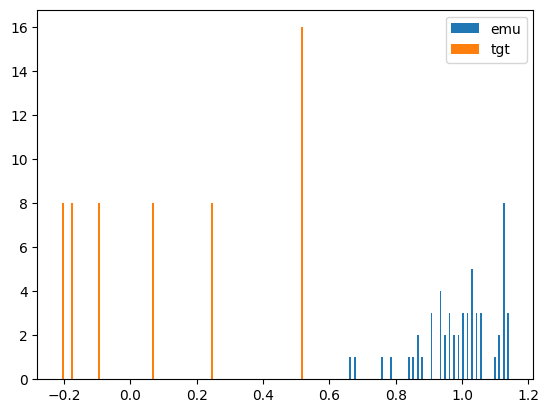

In [110]:
ivar = 0
# filtered = w.numpy().flatten()>0.5
mu_safe_arr = np.array(mu_safe_list)
y_true_safe_arr = np.array(y_true_safe_list)

emu_vs_tgt = [mu_safe_arr[:,:,ivar].flatten(), y_true_safe_arr[:,:,ivar].flatten()]
_ = plt.hist(emu_vs_tgt, bins=100)
plt.legend(['emu', 'tgt'])

# this is a histogram comparing range of target vs emulated constraint variables (in normalized scale). 
# having roughly the same range is indeed a good news, but otherwise it doesn't gaurantee a failure either. 
# could suggest either that the prior guess is way off or some structural issues. 

In [111]:
# Static diagonal preconditioner - pilot run to estimate sigma

initial_state = tf.random.normal([nchains, npar], seed=1) * 0.1
pilot_hmc = tfp.mcmc.HamiltonianMonteCarlo(get_BOSSemu_lp, step_size=0.0005, num_leapfrog_steps=5)
@tf.function
def run_pilot_chain():
    return tfp.mcmc.sample_chain(num_results=100, num_burnin_steps=0,
                                   current_state=initial_state, kernel=pilot_hmc, 
                                   trace_fn=(lambda current_state, kernel_results: kernel_results), 
                                   seed=1)
z_pilot, kr_pilot = run_pilot_chain()

var = tf.math.reduce_variance(z_pilot, axis=[0,1]) + 1e-6
sigma = tf.sqrt(var)  # shape [npar]
print(sigma)

tf.Tensor(
[0.10410159 0.08832697 0.09780264 0.04438896 0.08450889 0.05590631
 0.07513689 0.10431639 0.13816926 0.12638646 0.11785048 0.0921867
 0.12412258 0.11099912 0.10151243 0.12844943 0.11579335 0.09467807
 0.08688977 0.09169291 0.11298636 0.05464901 0.09217339], shape=(23,), dtype=float32)


## actual run

In [112]:
stepsize = 0.1
bij = tfb.Blockwise([tfb.Sigmoid()] * npar)
rv0 = tfs.RunningVariance.from_stats(
    num_samples=tf.constant(0., initial_state.dtype),   # “empty” running variance
    mean=tf.zeros([npar], initial_state.dtype),
    variance=tf.ones([npar], initial_state.dtype),         # start with I
)

hmc = tfp.mcmc.HamiltonianMonteCarlo(get_BOSSemu_lp, step_size=stepsize, num_leapfrog_steps=3)
DA = tfp.mcmc.DualAveragingStepSizeAdaptation(
        inner_kernel=hmc,
        num_adaptation_steps=int(num_burnin_steps * 0.5),
        target_accept_prob=0.75,
        )

precond = tfp.bijectors.Scale(sigma)

TTK = tfp.mcmc.TransformedTransitionKernel(
    bijector=precond,
    inner_kernel=DA,
)

start = time.time()

@tf.function
def run_chain():
    return tfp.mcmc.sample_chain(num_results=num_samples,
        current_state=initial_state,   # or your initial_state
        kernel=TTK,
        num_burnin_steps=num_burnin_steps,
        trace_fn=(lambda current_state, kernel_results: kernel_results),
        seed=0)

samples, kr = run_chain()

end = time.time()
print(end-start)

252.62124967575073


acceptance rate: [0.7486 0.7168 0.7518 0.7199 0.7047 0.715  0.7306 0.7095]


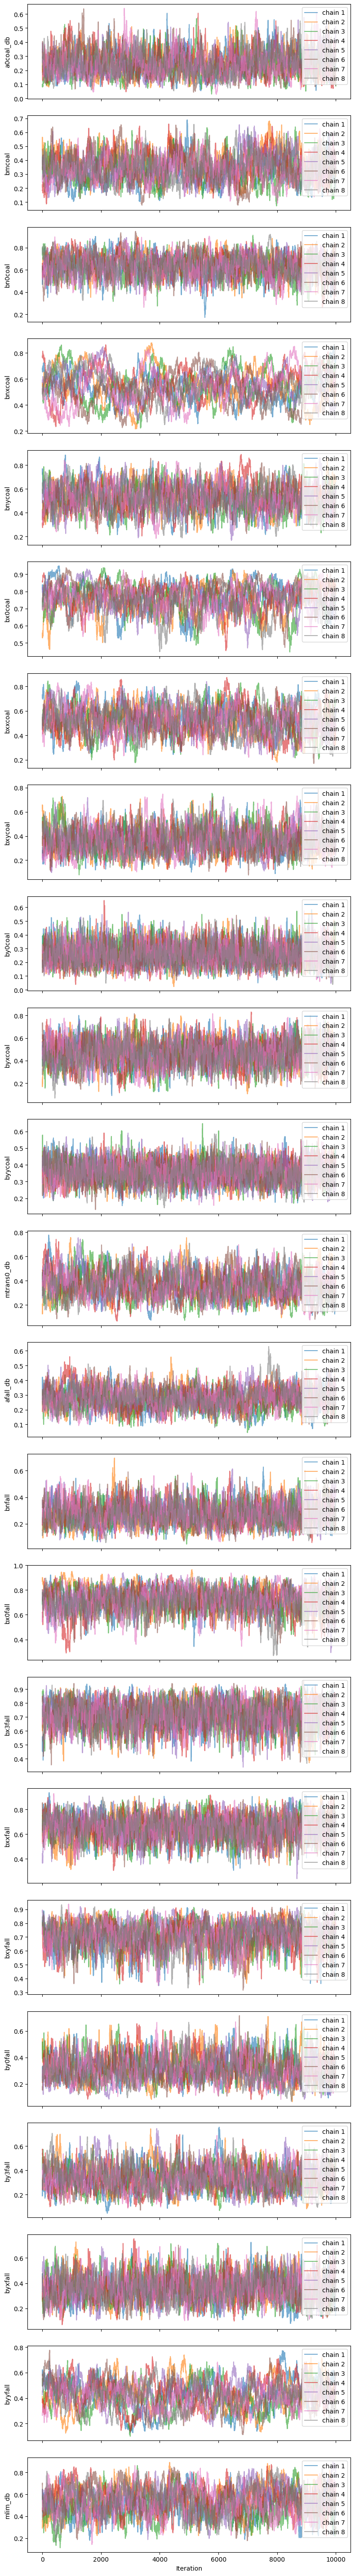

[[ 65.83132   67.72503   77.78477   28.56988   51.549965  35.413773
   51.636    112.595436 190.96387   57.379463  78.724335  70.64135
   52.378345 152.35327  136.16826  131.58105  104.24484   88.65373
   79.033516  61.664135  79.197235  16.165018  61.925495]
 [107.045265  43.186096  82.85954   23.057043  44.553036  44.774845
   42.32731   77.504776 200.85098   76.49567  142.10655   55.893562
   80.96268  104.725075  27.792946  92.108284  61.437244  66.43377
   51.895477  50.842175  70.149895  28.25314   51.789536]
 [117.25961   68.40498  109.39895   22.699541 116.35494   43.07703
   44.02084   48.939743 187.04517   78.88738  164.18443   37.809303
   92.45259  150.7755   152.25244  134.61662  107.54337  102.13999
   89.984436 107.74593  118.965416  31.51174   40.733295]
 [ 96.76206   57.078964  91.082504  19.017193  45.10165   28.240404
   50.28322  119.30742  197.92293   63.513927 135.55267   47.158188
   25.764801 116.3279    54.128082 156.37686   78.7291    78.90621
   48.23729   63

In [113]:
print("acceptance rate:", sum(kr.inner_results.inner_results.is_accepted.numpy())/num_samples)
# param_names_incl_sigma = param_names + ['sigma']
transformed_samples = tfb.Sigmoid().forward(samples)
# transformed_samples = tf.concat([tfb.Sigmoid().forward(samples[:,:,:-1]), tf.exp(samples[:,:,-1:])], axis=2)
mf.plot_traces(transformed_samples, param_names)

print(tfp.mcmc.effective_sample_size(samples).numpy())
print(tfp.mcmc.potential_scale_reduction(samples).numpy())

In [114]:
print("acc rate:", kr.inner_results.inner_results.is_accepted.numpy().mean())
# print("step_size:", kr.inner_results.step_size.numpy())
print("step_size range:", kr.inner_results.new_step_size.numpy().min(), kr.inner_results.new_step_size.numpy().max())
# print("leapfrog steps avg:", kr.inner_results.leapfrogs_taken.numpy().mean()).
print("avg log_accept_ratio:", np.nanmean(kr.inner_results.inner_results.log_accept_ratio))

acc rate: 0.7246125
step_size range: 0.38017634 0.38017634
avg log_accept_ratio: -0.66347784


In [115]:
with tf.GradientTape() as gt:
  gt.watch(initial_state)
  logprob = get_BOSSemu_lp(initial_state)
grad = gt.gradient(logprob, initial_state)
print("||grad|| ≈", tf.norm(grad).numpy())

||grad|| ≈ 147.80075


In [116]:
with tf.GradientTape() as t:
    t.watch(initial_state)                # unconstrained params you sample in
    lprob = get_BOSSemu_lp(initial_state)
g = t.gradient(lprob, initial_state)         # shape [..., D]
gn = tf.math.reduce_std(g, axis=0)  # per-dim
print(gn)

tf.Tensor(
[ 1.3984245  2.3226087  4.4060316  2.3096771  1.7511154  3.1956549
  1.5430164  6.310346   4.739932   4.6754446 14.138497   4.035882
  7.7470417  6.3892927  2.6231823  3.8102286  8.835476   2.7409396
  0.8179474  3.8787043  2.436228   2.9203305 12.160167 ], shape=(23,), dtype=float32)


## postprocessing

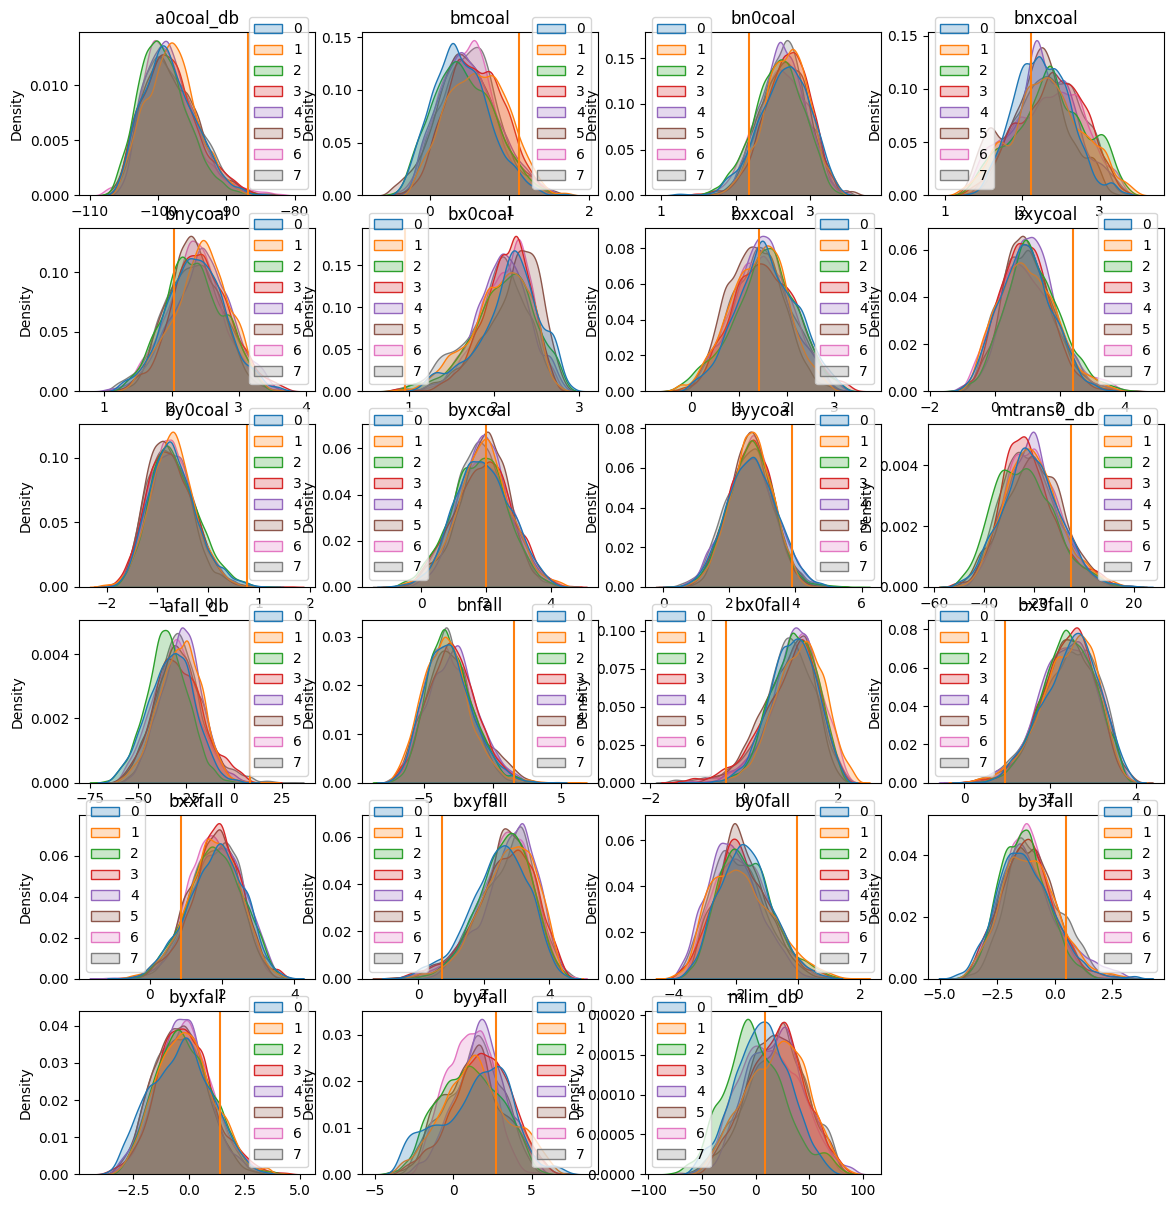

In [117]:
import seaborn as sns

IC_col = tf.tile(tf.expand_dims(IC_norm[0, :n_init], 0), [num_samples, 1])
# IC_col = tf.tile(tf.expand_dims(IC_norm[0, :n_init], 0), [num_samples, 1])
IC_col3d = tf.tile(IC_col[:, None, :], [1, nchains, 1])
# w_col3d = tf.tile(w_col[:, None, :], [1, nchains, 1])
samples_with_ic = tf.concat([IC_col3d, transformed_samples], axis=2)

samples_with_ic_raw_vals = np.zeros(samples_with_ic.shape, dtype=np.float32)
for ichain in range(nchains):
    samples_with_ic_raw_vals[:, ichain, :] = scalers['x'].inverse_transform(samples_with_ic[:, ichain, :])

samples_raw_vals = samples_with_ic_raw_vals[:,:,n_init:]

np.mean(samples_with_ic[:,:,n_init:].numpy().reshape(num_samples*nchains,nparam), axis=0)
# samples_with_ic[:,:,n_init:].shape

samples_origval = samples_raw_vals
fig = plt.figure(figsize=(14,25))
gs = gridspec.GridSpec(10, 4)
for ipost in range(samples_origval.shape[-1]):
# for iparam, param_name in enumerate(param_names):
    param_name = param_names[ipost]
    ax = fig.add_subplot(gs[ipost])
    sns.kdeplot(samples_origval[:,:,ipost], fill=True)
    plt.axvline(param_mean[ipost], color='tab:orange')
    # plt.axvline(target_param_mean[ipost], color='tab:blue')
    plt.title(param_name)

$$
\frac{dM_i}{dt} \propto a_{0,coal}M^2_0\frac{\tilde{m}^{b_{n,i}}}{\tilde{m}^{b_{m}} + m_{trans}^{b_m}}K^{b_{x,i}}_{0,3,x}K^{b_{y,i}}_{3,x,y}
$$

x=4, y=6 for ith order moment

## validation

/home/arthurhu/BOSS_PPE/emulator_fun.py:441: RuntimeWarning: overflow encountered in sinh
  inv_smooth_linlog = lambda y, eff0: eff0*np.sinh(y/eff0)
/home/arthurhu/BOSS_PPE/emulator_fun.py:441: RuntimeWarning: overflow encountered in sinh
  inv_smooth_linlog = lambda y, eff0: eff0*np.sinh(y/eff0)
/home/arthurhu/BOSS_PPE/emulator_fun.py:441: RuntimeWarning: overflow encountered in sinh
  inv_smooth_linlog = lambda y, eff0: eff0*np.sinh(y/eff0)
/home/arthurhu/BOSS_PPE/emulator_fun.py:441: RuntimeWarning: overflow encountered in sinh
  inv_smooth_linlog = lambda y, eff0: eff0*np.sinh(y/eff0)


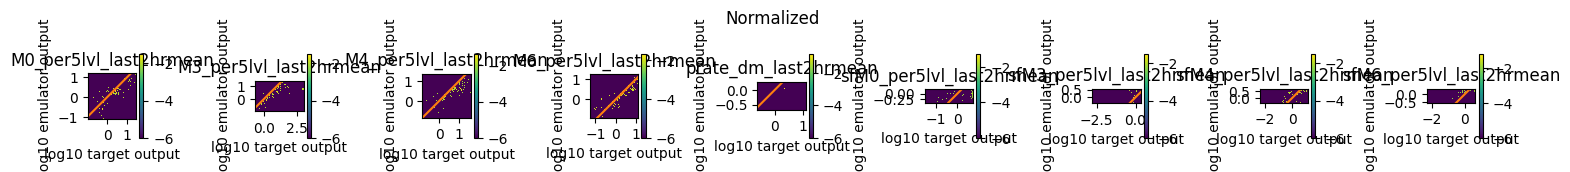

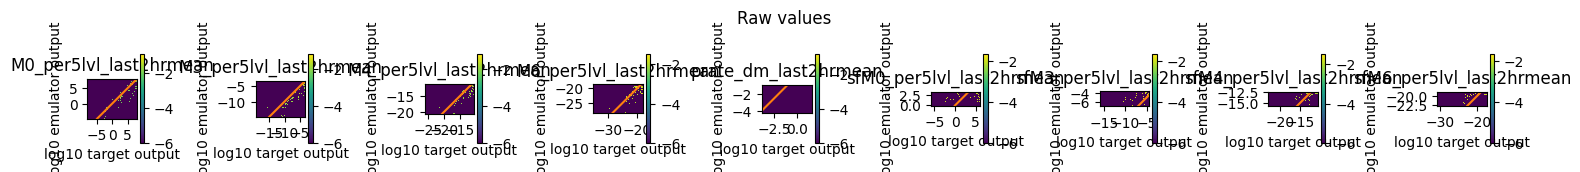

In [118]:
tsamples_combine_chains = transformed_samples.numpy().reshape(num_samples*nchains, npar)
meanresult = np.mean(tsamples_combine_chains, axis=0)
meanresult = tf.expand_dims(meanresult, axis=0)
meanresult_tiled = tf.tile(meanresult, [IC_norm.shape[0], 1])
meanresults_incl_ics = tf.concat([IC_norm, meanresult_tiled], axis=1)

ef.plot_emulator_results(meanresults_incl_ics, tgt_data, best_model, ppe_info, transform_method, scalers)

# Save MCMC results

## save posterior PDF into netCDF

In [119]:
nbins = 50
count = {}
bins = {}
sample_sum_chains = samples_origval.reshape(num_samples*nchains,nparam)
for iparam, param_name in enumerate(param_names):
    count[param_name], bins[param_name] = np.histogram(sample_sum_chains[:, iparam], bins=nbins)
    count[param_name] = count[param_name]/np.sum(count[param_name])

import netCDF4 as nc
import numpy as np

# Create a new NetCDF file
ncfile = nc.Dataset(f'MCMC_posterior/{run_name}_post.nc', mode='w', format='NETCDF4')

# Create the dimension for parameters and bins
param_dim = ncfile.createDimension('nparam', len(param_names))
binmean_dim = ncfile.createDimension('nbin', nbins)
binedge_dim = ncfile.createDimension('nbinedge', nbins+1)

# Create variables
param_var = ncfile.createVariable('param_names', str, ('nparam',))
density_var = ncfile.createVariable('density', np.float32, ('nparam', 'nbin',))
bin_edges_var = ncfile.createVariable('bin_edges', np.float32, ('nparam', 'nbinedge',))
# sigma_dens_var = ncfile.createVariable('sigma_dens', np.float32, ('nbin',))
# sigma_edge_var = ncfile.createVariable('sigma_edge', np.float32, ('nbinedge',))

# Assign data
param_var[:] = np.array(param_names, dtype='S')
for i, pname in enumerate(param_names):
    # bins[pname] has nbins+1 edges, so we store the left edges for each bin
    density_var[i, :] = count[pname]
    bin_edges_var[i, :] = bins[pname]

# sigma_dens_var[:] = count['sigma'].astype('float32')
# sigma_edge_var[:] = bins['sigma']
ncfile.close()

## save samples into arviz style netcdf output

In [120]:
with nc.Dataset(f"{lp.nc_dir}{filename}") as ds:
    param_idx_group, perturbed_pgroup = ef.get_param_interest_idx(ds, return_perturbed_groupname=True)

# Reshape samples_origval to (nchains, num_samples, nparam) if not already
# samples_origval is assumed to be (nchains, num_samples, nparam) or (num_samples, nchains, nparam)
# If it's (num_samples, nchains, nparam), transpose to (nchains, num_samples, nparam)
if samples_origval.shape[0] == nchains and samples_origval.shape[1] == num_samples:
    posterior_samples = samples_origval
elif samples_origval.shape[1] == nchains and samples_origval.shape[0] == num_samples:
    posterior_samples = np.transpose(samples_origval, (1,0,2))
else:
    posterior_samples = samples_origval.reshape(nchains, num_samples, nparam)

# Build a dict for InferenceData
for igroup, (param_idx, pgname) in enumerate(zip(param_idx_group, perturbed_pgroup)):
    posterior_dict = {}
    for i in range(len(param_idx)):
        pname = param_names[i]
        # shape: (chain, draw)
        posterior_dict[pname] = posterior_samples[:,:,i]
    
    # Create InferenceData object
    idata = az.from_dict(posterior=posterior_dict)
    
    # Save to NetCDF
    idata.to_netcdf(f'MCMC_posterior/{run_name}_{pgname}_posterior_arviz.nc')

## update params csv

In [121]:
original_params = pd.read_csv(orig_param_csv)
updated_params = original_params.copy()
for iparam, param_name in enumerate(param_names):
    binmean = (bins[param_name][1:] + bins[param_name][:-1])/2
    weighted_mean = np.average(binmean, weights=count[param_name])
    weighted_std = np.sqrt(np.cov(binmean, aweights=count[param_name], ddof=0))
    updated_params.loc[0, param_name] = weighted_mean
    updated_params.loc[2, param_name] = weighted_std

# coal_density = pd.read_csv('MCMC_posterior/coal_r2_param_density.csv')
# coal_param_names = coal_density.keys()[1:].to_list()
# coal_bin_edges = pd.read_csv('MCMC_posterior/coal_r2_param_bins.csv')

# for iparam, param_name in enumerate(coal_param_names):
#     binmean = (coal_bin_edges[param_name][1:].to_numpy() + coal_bin_edges[param_name][:-1].to_numpy())/2
#     weighted_mean = np.average(binmean, weights=coal_density[param_name])
#     updated_params.loc[0, param_name] = weighted_mean

updated_params.to_csv(f'{lp.param_dir}/param_{run_name}_r1.csv', index=False)


In [124]:
pd.set_option('display.max_columns', None)
updated_params.iloc[:,17:]

a0coal_db    bmcoal   bn0coal   bnxcoal   bnycoal   bx0coal   bxxcoal  \
0 -98.389485  0.487206  2.638975  2.306284  2.370701  2.112857  1.477005   
1   0.130643  0.008288  0.006519  0.006649  0.006923  0.009375  0.011378   
2   3.846602  0.365596  0.322333  0.425278  0.427726  0.341692  0.622932   

    bxycoal   by0coal   byxcoal   byycoal  mtrans0_db   afall_db    bnfall  \
0  1.025791 -0.724744  1.875311  2.643518  -21.557136 -29.934559 -3.131778   
1  0.014938  0.012429  0.015692  0.021322    0.231197   1.093249  0.220264   
2  0.829951  0.452483  0.834710  0.692205   11.214618  11.821731  1.763519   

    bx0fall   bx3fall   bxxfall   bxyfall   by0fall   by3fall   byxfall  \
0  1.007070  2.410258  1.795560  2.637215 -1.828722 -1.170745 -0.289152   
1  0.013566  0.014816  0.015543  0.019498  0.019935  0.021920  0.023036   
2  0.546624  0.644430  0.717875  0.858841  0.886965  1.152859  1.245322   

    byyfall    mlim_db  
0  1.358973  13.428482  
1  0.028926   0.800699  
2  1.905635  28.023539

In [123]:
updated_params

Unnamed: 0  a0evap1_db  a0evap2_db  bm0evap1  bm0evap2  bx0evap1  bx0evap2  \
0       mean  -23.530267  -53.491215  0.006542  0.322378  2.012595  4.758512   
1         sd    2.255964    3.114923  0.003238  0.132059  0.168649  0.137407   
2        isd    2.207711    2.686361  0.003169  0.076952  0.130516  0.152637   

   by0evap1  by0evap2   aevap_db    bmevap   bx3evap   bxxevap   bxyevap  \
0  1.130926  1.087831 -69.430048  0.381905  0.018227 -1.455336 -0.167408   
1  0.390538  0.169134   0.203477  0.008552  0.076802  0.076864  0.084023   
2  0.270169  0.130546   0.656400  0.025688  0.115132  0.255519  0.154710   

    by3evap   byxevap   byyevap  a0coal_db    bmcoal   bn0coal   bnxcoal  \
0  2.848483 -0.247178 -1.579327 -98.389485  0.487206  2.638975  2.306284   
1  0.108241  0.105786  0.100642   0.130643  0.008288  0.006519  0.006649   
2  0.265072  0.343386  0.300062   3.846602  0.365596  0.322333  0.425278   

    bnycoal   bx0coal   bxxcoal   bxycoal   by0coal   byxcoal   byycoal  \
0  2.370701  2.112857  1.477005  1.025791 -0.724744  1.875311  2.643518   
1  0.006923  0.009375  0.011378  0.014938  0.012429  0.015692  0.021322   
2  0.427726  0.341692  0.622932  0.829951  0.452483  0.834710  0.692205   

   mtrans0_db   afall_db    bnfall   bx0fall   bx3fall   bxxfall   bxyfall  \
0  -21.557136 -29.934559 -3.131778  1.007070  2.410258  1.795560  2.637215   
1    0.231197   1.093249  0.220264  0.013566  0.014816  0.015543  0.019498   
2   11.214618  11.821731  1.763519  0.546624  0.644430  0.717875  0.858841   

    by0fall   by3fall   byxfall   byyfall    mlim_db  
0 -1.828722 -1.170745 -0.289152  1.358973  13.428482  
1  0.019935  0.021920  0.023036  0.028926   0.800699  
2  0.886965  1.152859  1.245322  1.905635  28.023539